# Group assignment
1. Regroup according to your group number and select the corresponding parameter sets (in DAY5/parameters for group.xlsx)

2. Copy the notebook 9. Fill out the parameters marked with a ‘??’ with your values and put the resulting plots in a PowerPoint.

3. Gather according to the soil Van Genuchten parameters and the boundary conditions.

4. Discuss the effect of the plant and soil parameters on the outputs of the 1D simulation. E.g.: 

    4.1. Do we have water stress? If yes, when? How do the effective soil water content ?

    4.2. How do hydraulic and architectural traits affect stress level? And soil water storage?  

    4.3. Can you imagine (and test) ideal traits that would minimize the stress?

5. Use the plots to prepare a short presentation (max 10mn)

In [1]:
import timeit
from functools import partial

import matplotlib.pyplot as plt
import numpy as np

import functional.van_genuchten as vg
import plantbox as pb
import visualisation.vtk_plot as vp
from functional.Perirhizal import PerirhizalPython as Perirhizal
from functional.PlantHydraulicModel import HydraulicModel_Doussan, HydraulicModel_Meunier
from functional.PlantHydraulicParameters import PlantHydraulicParameters
from richards import RichardsWrapper  # Python part
from rosi_richards import RichardsSP  # C++ part (Dumux binding)

sourcedir = "/home/jhack/phd/CPlantBox/"

In [2]:
def make_source(q: np.ndarray, area: float) -> dict[int, float]:
    """
    Create a source term dictionary for the soil model from given fluxes and area.
    
    Args:
        q (np.ndarray): Array of fluxes [cm/day].
        area (float): Area of each soil cell [cm²].
    
    Returns:
        dict[int, float]: Dictionary mapping cell indices to source terms [cm³/day].
    """
    s = {}
    for i in range(len(q)):
        if not np.isnan(q[i]):
            s[i] = -q[i] * area  # Negative because flux into root is a sink in soil

    return s

def soil_picker(x: float, y: float, z: float, soil_model) -> int:
    """
    Maps a 3D coordinate (x, y, z) to the corresponding soil grid cell index.

    This function wraps the Richards solver's `pick()` method, which returns
    the index of the grid cell containing the given coordinates. It is used
    to couple plant root segments to the soil model in CPlantBox simulations.

    Args:
        x (float): X-coordinate [cm].
        y (float): Y-coordinate [cm].
        z (float): Z-coordinate [cm].
        soil_model: The soil model object (e.g. a RichardsWrapper instance).

    Returns:
        int: The index of the soil grid cell containing the point (x, y, z).
    """
    return soil_model.pick([x, y, z])

def sinusoidal(t: float) -> float:
    """ 
    Sinusoidal function (used for transpiration) (integral over one day is 1).
    
    Args:
        t (float): Time [days].
    
    Returns:
        float: Sinusoidal value at time t.
    """
    return np.sin(2. * np.pi * np.array(t) - 0.5 * np.pi) + 1.

initializing look up tables
done
Computed bounding box tree with 199 nodes for 100 grid entities in 0.0002757 seconds.
Computed bounding box tree with 199 nodes for 100 grid entities in 4.64e-05 seconds.
MappedPlant::initializeLB 
Seed::initialize: RootSystem 
Seed::initialize: Shoot borne definition is DEPRICATED, shoot borne roots will be handeled like basal roots 
Organism::simulate: from 0 to 56 days
nodes moved 0
new nodes added 48197
segments added 48197
Number of segments 48198, including 48197 new 
PlantHydraulicModel.test():
48199 nodes:
Node 0 [ 0.1  0.  -3. ]
Node 1 [ 0.  0. -3.]
Node 2 [ 0.0883762   0.0353676  -3.49085515]
Node 3 [ 0.21586876  0.01689569 -3.97397464]
Node 4 [ 0.21646239 -0.09847443 -4.33250925]
48198 segments:
Segment 0 [0 1] subType 0
Segment 1 [1 2] subType 1
Segment 2 [2 3] subType 1
Segment 3 [3 4] subType 1
Segment 4 [4 5] subType 2
Collar segment index 0
Collar segment [0 1]
0 segments with length < 1.e-5 cm
6 different root types from 0 to 5
ages fro

/home/jhack/phd/CPlantBox/src/functional/Perirhizal.py:105: RuntimeWarning: divide by zero encountered in divide
  r_phriz = np.divide(1., np.sqrt(np.pi * rld))  # outer perirhizal radii per layer [cm]
/home/jhack/phd/CPlantBox/src/functional/Perirhizal.py:108: RuntimeWarning: invalid value encountered in add
  b = np.divide(2 * (rho2 - np.ones(rho2.shape)) , np.ones(rho2.shape) - 0.53 * 0.53 * rho2 + 2 * rho2 * (np.log(rho) + np.log(0.53)))  # [1], see Eqn [8]
/tmp/ipykernel_320252/2850069223.py:157: RuntimeWarning: invalid value encountered in divide
  q_s = alphaSUF * tp / omega_c
/tmp/ipykernel_320252/2850069223.py:161: RuntimeWarning: invalid value encountered in divide
  q_us = alphaSUF * tp / omega_c - np.divide(alphaSUF, denumerator) * (omega / omega_c - 1) * tp
/tmp/ipykernel_320252/2850069223.py:161: RuntimeWarning: divide by zero encountered in scalar divide
  q_us = alphaSUF * tp / omega_c - np.divide(alphaSUF, denumerator) * (omega / omega_c - 1) * tp
/tmp/ipykernel_320252

 -- Using the default temperature of [                                                                                                    ] | potential 0.00 | actual 0.00 | [-611.38, -603.00] cm soil at 0.041666666666666664 days
293.15 in the entire domain. Overload temperatureAtPos() in your spatial params class to define a custom temperature field.Or provide the preferred domain temperature via the SpatialParams.Temperature parameter.
[*                                                                                                   ] | potential 20.72 | actual 20.72 | [-611.38, -602.94] cm soil at 0.08333333333333333 days
[*                                                                                                   ] | potential 81.46 | actual 81.46 | [-612.76, -602.88] cm soil at 0.125 days
[**                                                                                                  ] | potential 178.08 | actual 178.08 | [-618.83, -602.82] cm soil at 0.166666666666666

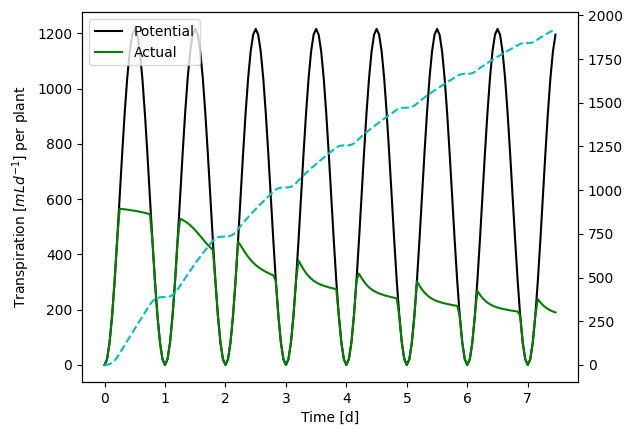

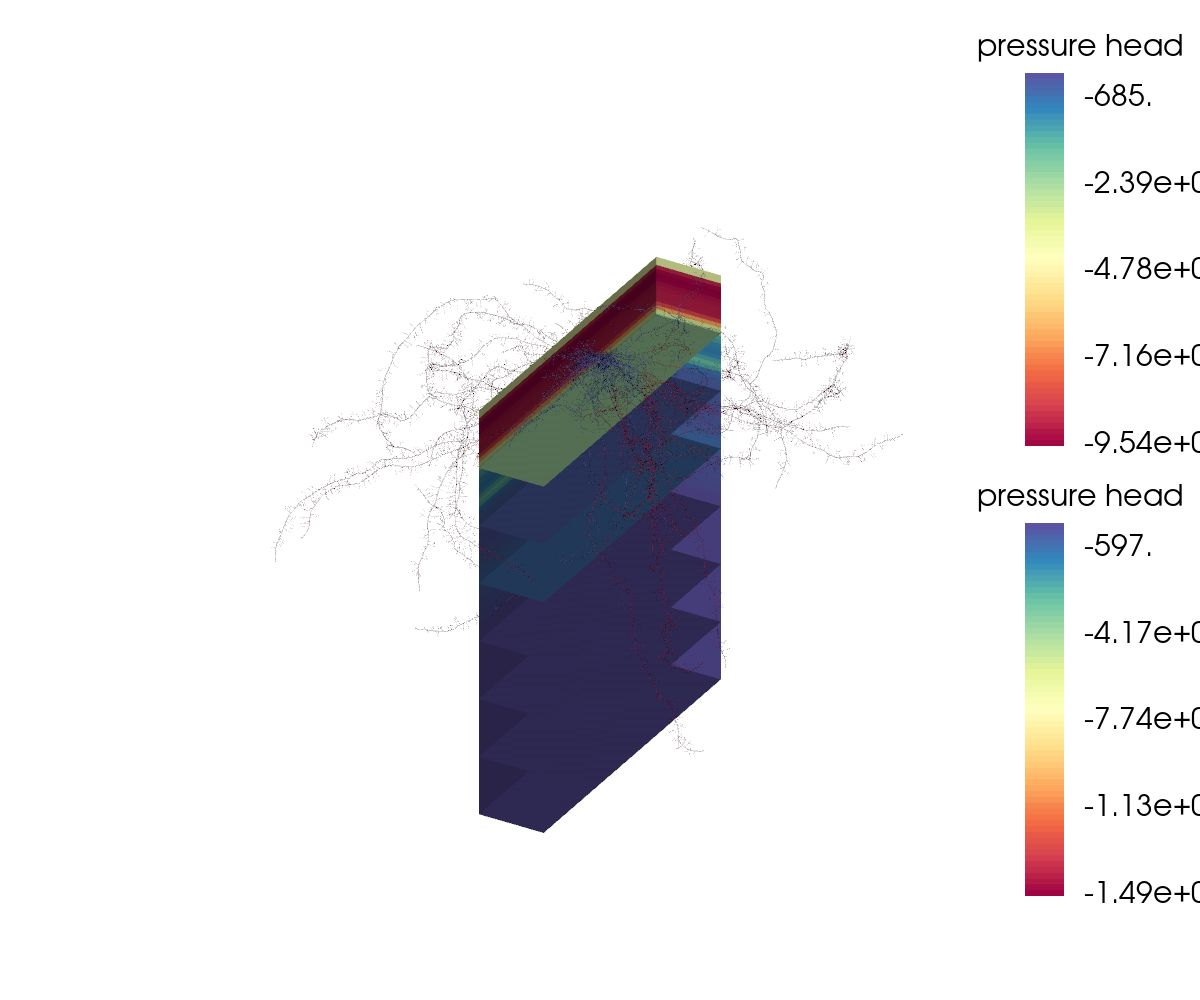

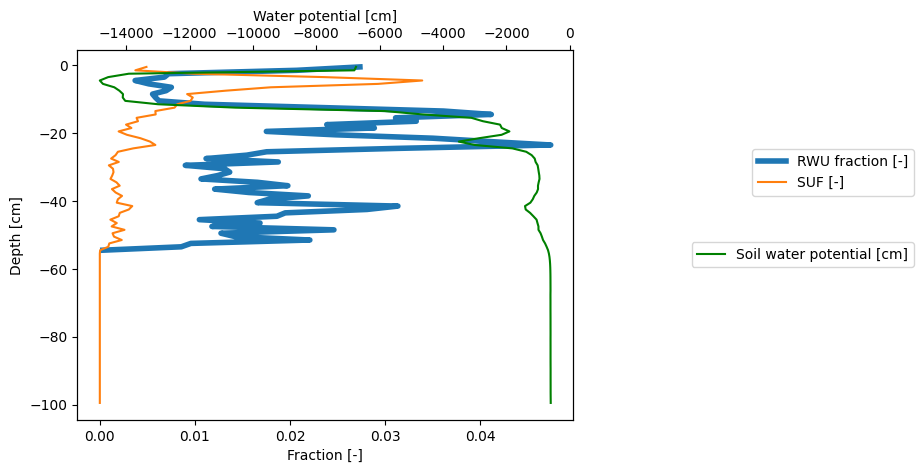

/tmp/ipykernel_320252/2850069223.py:233: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend(bbox_to_anchor=(1.7, 0.5))


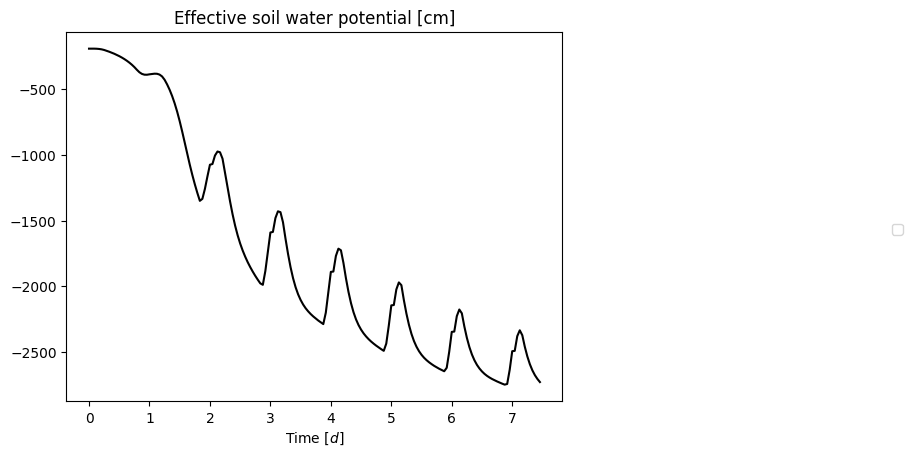

/tmp/ipykernel_320252/2850069223.py:241: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend(bbox_to_anchor=(1.7, 0.5))


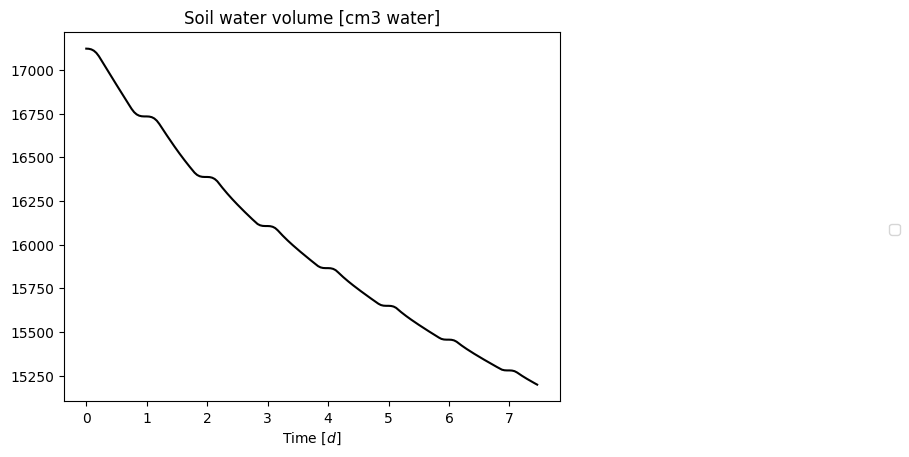

In [3]:
""" Parameters """  
verbose = False

depth = 100    
min_b = np.array([-38., -8., -depth])
max_b = np.array([38., 8., 0.])
cell_number = [1, 1,depth]  # [cm3]

path = sourcedir + "modelparameter/structural/rootsystem/"
name = "Zeamays_synMRI_modified"  #"Anagallis_femina_Leitner_2010"  # Zea_mays_1_Leitner_2010, Zeamays_synMRI.xml  <<<<-------

trans_ = 0.5 # other value 1
trans = (max_b[0] - min_b[0]) * (max_b[1] - min_b[1]) * trans_  # cm3 / day
wilting_point = -15000  # cm
rs_age = 8 * 7  # 56 days  # root system initial age [day]
sim_time = 7.5  # [day]
dt = 3600. / (24 * 3600)  # [days] 

# Define van Genuchten parameters for sand, loam and clay  
# theta_r (-), theta_s (-), alpha (1/cm), n (-), Ks (cm d-1)
soil_params = [0.078, 0.43, 0.036, 1.56, 24.94] # other value set [0.065, 0.41, 0.075, 1.89, 106.1]
sp = vg.Parameters(soil_params)  # needed for Perirhizal class
vg.create_mfp_lookup(sp, wilting_point = -15000, n = 1501)  # needed for Perirhizal class


""" Initialize macroscopic soil model """
s = RichardsWrapper(RichardsSP())  
s.initialize()
s.createGrid(min_b, max_b, cell_number, periodic = True)  # [cm]

# initial soil water potential
s.setHomogeneousIC(-600, False)  # [cm] False = matrix, True, = total potential; other initial water potential -1200

# upper and lower boundary conditions
s.setTopBC("noFlux") # other value "constantFlux", 1
s.setBotBC("noFlux") # other value "freeDrainage"

s.setVGParameters([soil_params])
s.setParameter("Soil.SourceSlope", "100") 
s.initializeProblem()
s.setCriticalPressure(wilting_point)  

""" Initialize xylem model """
plant = pb.MappedPlant() 
plant.enableExtraNode()

# plant structural parameters
plant.readParameters(path + name + ".xml")
for p in plant.getOrganRandomParameter(pb.root):
    if (p.subType == 1): # tap root
        p.r = 2 # other value 1.2
        p.ln = 1.7 # other value 0.69
        p.lmax = 165 # other value 135
        p.tropismS = 0.3 # other value 0.15
        pass
    if (p.subType == 4): # basal root
        p.r = 2 # other value 1.2
        p.ln = 0.71 # other value 0.28
        p.lmax = 165 # other value 135
        p.tropismS = 0.3 # other value 0.15
        p.theta = 0.74 # other value 1.85
    if (p.subType == 5): # shoot born root
        p.r = 2 # other value 1.2
        p.ln = 0.71 # other value 0.28
        p.lmax = 165 # other value 135


sdf = pb.SDF_PlantBox(np.inf, np.inf, max_b[2] - min_b[2] - 0.5)  
plant.setGeometry(sdf)  
plant.setRectangularGrid(pb.Vector3d(min_b), pb.Vector3d(max_b), pb.Vector3d(cell_number), False, False)  # needed for Perirhizal class

""" root hydraulic properties """
# axial and radial conductivities
param = PlantHydraulicParameters()  
kr_main_roots_max = 0.000008 # other value 0.000125
kx_main_roots_max = 8.2 # other value 1
kr_lat_roots_max = 0.0005 # other value 0.0002
kx_lat_roots_max = 0.017 # other value 0.0017

kr_main_roots_age = np.array([0., 12.5, 20.9, 44.6, 62.7, 100])
kr_main_roots_val = np.array([kr_main_roots_max, kr_main_roots_max, 
                              kr_main_roots_max/2, kr_main_roots_max/2, 
                              kr_main_roots_max/10, kr_main_roots_max/10])

kr_lat_roots_age = np.array([0., 10, 15, 25])
kr_lat_roots_val = np.array([kr_lat_roots_max, kr_lat_roots_max, 
                             kr_lat_roots_max/10, kr_lat_roots_max/10])
param.set_kr_age_dependent(kr_main_roots_age, kr_main_roots_val, subType = [1, 4, 5])  
param.set_kr_age_dependent(kr_lat_roots_age, kr_lat_roots_val, subType = [2, 3])


kx_main_roots_age = np.array([0., 18.3, 21, 47, 61, 100])
kx_main_roots_val = np.array([kx_main_roots_max/200, kx_main_roots_max/200, 
                              kx_main_roots_max/10, kx_main_roots_max/10, 
                              kx_main_roots_max, kx_main_roots_max])

kx_lat_roots_age = np.array([0., 9, 13, 20, 25])
kx_lat_roots_val = np.array([kx_lat_roots_max/200, kx_lat_roots_max/100, 
                             kx_lat_roots_max/4, kx_lat_roots_max, kx_lat_roots_max])

param.set_kx_age_dependent(kx_main_roots_age, kx_main_roots_val, subType = [1, 4, 5])
param.set_kx_age_dependent(kx_lat_roots_age, kx_lat_roots_val, subType = [2, 3])

hm = HydraulicModel_Doussan(plant, param)
hm.wilting_point = wilting_point  

""" Coupling (map indices) """
picker = partial(soil_picker, soil_model = s)  # wrap the function soil_picker
plant.setSoilGrid(picker)

plant.initialize(True)
plant.simulate(rs_age, True)
hm.test() 

peri = Perirhizal(plant)
h_bs = s.getSolutionHead()
h_sr = np.ones(h_bs.shape) * wilting_point

""" Numerical solution """
start_time = timeit.default_timer()
t = 0.
time_, tact_, h_eff_, water_volume_ = [], [], [], []
N = round(sim_time / dt)
area = (plant.maxBound.x - plant.minBound.x) * (plant.maxBound.y - plant.minBound.y)  # [cm2]

for i in range(0, N): 

    h_bs = s.getSolutionHead()
    h_bs = np.array(plant.matric2total(h_bs))

    start_time_ao = timeit.default_timer()

    hm.update(rs_age + t)

    # Alpha: root system averaged stress factor
    # krs, _ = hm.get_krs(rs_age + sim_time)  # [cm2/day] (could be precomputed for static case)
    krs = hm.krs
    krs = krs / area

    k_srs = hm.get_soil_rootsystem_conductance(rs_age + sim_time, h_bs, wilting_point, sp)
    h_bs_diff = h_bs - np.ones(h_bs.shape) * wilting_point
    alpha = np.multiply(k_srs, h_bs_diff) / (-krs * wilting_point)  # [1]

    # Omega: root system averaged stress factor
    # suf_ = hm.get_suf(rs_age + sim_time)
    suf_ = hm.suf
    suf = peri.aggregate(suf_[0,:])
    alphaSUF = np.multiply(alpha, suf)
    omega = np.nansum(alphaSUF)  # note that nan are treated as 0

    # Omega_c: critical stress factor
    tp = trans * sinusoidal(t) / area  # potential tranpiration [cm3 day-1] -> [cm day-1]
    
    omega_c = tp / (-wilting_point * krs)

    # Sink, stressed
    q_s = alphaSUF * tp / omega_c

    # Sink, unstressed
    denumerator = np.multiply(h_bs_diff, np.nansum(np.divide(alphaSUF, h_bs_diff)))
    q_us = alphaSUF * tp / omega_c - np.divide(alphaSUF, denumerator) * (omega / omega_c - 1) * tp

    
    if omega < omega_c:
        q = q_s
    else:
        q = q_us

    start_time_soil = timeit.default_timer()

    fluxes = make_source(q, area)
    s.setSource(fluxes)
    s.solve(dt) 

    
    water_volume = s.getWaterVolume() 


    water_volume_.append(water_volume)
    h_eff_.append(sum(suf*h_bs))
    time_.append(t)
    tact_.append(-np.nansum(q) * area) 

    n = round(float(i) / float(N) * 100.)  
    print(
        f"[{'*' * n}{' ' * (100 - n)}] | "
        f"potential {tp * area:.2f} | actual {np.nansum(q) * area:.2f} | [{np.min(h_bs):.2f}, {np.max(h_bs):.2f}] cm soil at {s.simTime} days"
    )

    t += dt  # [day]

print ("Coupled benchmark solved in ", timeit.default_timer() - start_time, " s")

""" Get plots """
fig, ax1 = plt.subplots()
ax1.plot(time_, trans * sinusoidal(time_), 'k')  # potential transpiration
ax1.plot(time_, -np.array(tact_), 'g')  # actual transpiration
ax2 = ax1.twinx()
ax2.plot(time_, np.cumsum(-np.array(tact_) * dt), 'c--')  # cumulative transpiratio
ax1.set_xlabel("Time [d]")
ax1.set_ylabel("Transpiration $[mL d^{-1}]$ per plant")
ax1.legend(['Potential', 'Actual', 'Cumulative'], loc = 'upper left')
plt.show()
#fig.savefig("results/transpiration.jpg")
plt.close(fig)


vp.plot_roots_and_soil(hm.ms.mappedSegments(), "pressure head", hm.get_hs(h_bs), s, False, min_b, max_b, 
                       cell_number, 
                       interactiveImage = False)  # VTK vizualisation

depth_array = [cc[2] for cc in s.getCellCenters()]
fig, ax1 = plt.subplots()
ax1.plot(q/np.nansum(q), depth_array,label = "RWU fraction [-]", linewidth=4 )  
ax1.plot(suf, depth_array, label = "SUF [-]")
ax2 = ax1.twiny()
ax2.plot(h_bs, depth_array, label="Soil water potential [cm]",color='g') 
ax2.set_xlabel("Water potential [cm]") 
ax1.set_xlabel("Fraction [-]")
ax1.set_ylabel("Depth [cm]")
ax1.legend(bbox_to_anchor=(1.7, 0.75))
ax2.legend(bbox_to_anchor=(1.7, 0.5))
plt.show()
#fig.savefig("results/suf.jpg", bbox_inches="tight")
plt.close(fig)

    
fig, ax1 = plt.subplots() #water_volume_
ax1.plot(time_, h_eff_, 'k')  
#ax1.set_ylabel("Water potential $[cm]$")
ax1.set_title("Effective soil water potential [cm]") 
ax1.set_xlabel("Time $[d]$")
ax1.legend(bbox_to_anchor=(1.7, 0.5))
plt.show()
#fig.savefig("results/effective_soil_potential.jpg")
plt.close(fig)

fig, ax1 = plt.subplots() #water_volume_
ax1.plot(time_, water_volume_, 'k')  
ax1.set_xlabel("Time $[d]$")
ax1.legend(bbox_to_anchor=(1.7, 0.5))
ax1.set_title("Soil water volume [cm3 water]")  
#fig.savefig("results/water_volume.jpg")
plt.show()
plt.close(fig)
